In [ ]:
from qutip import * # qutip == 5.0.4
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# Hamiltonian
$$\begin{align}​
H(t) &= \sum_{i = j}^{n} \frac{\Omega_j(t)}{2} |1\rangle_j {}_j\langle r| + \text{h.c.} \\​
&+ \sum_{j <> k} B_{jk} |rr\rangle_{jk} {}_{jk}\langle rr|.​
\end{align}$$

# the Two Qubit System with Infinte Blockade Strength

In [61]:
N = 99 # number of time steps
dim = 4 
basis_state = [basis(dim,i) for i in range(dim)] # basis states
# in the basis of |10>, |0r>, |11>, |W>=(|1r>+|r1>)/sqrt2

method = 'BFGS'
sqrt2 = np.sqrt(2)

Omega_max = 1 # fix maximum Omega
T_max = 100000.0 # maximum time
T_list = np.linspace(0, T_max, 100)

# Initialize the state
psi_in = Qobj([1,0,1,0]/sqrt2) # |psi(0)> = |1>|0> + |1>|1> 

In [62]:
class Optimalization_2_qubits:
    # input T get optimal 1-F and optimized phi
    def __init__(self, T):
        self.T = T
        self.dt = T/N
        self.phi = np.random.uniform(0, 2*np.pi, N) # Random initial phase angles
        
    def get_H(self):
        phi = self.phi
        
        Omega = Omega_max * np.exp(1j*phi)# Global Pulse so Omega_1 = Omega_2 = Omega

        H = np.zeros((4,4)) # Hamiltonian matrix
        # in the basis of |01>, |0r>,|11>,|W>=(|1r>+|r1>)/sqr2
        H_list = [] # List to store Hamiltonian matrices
        
        for i in range(N):
            H[0,1] = Omega[i]/2 
            H[1,0] = Omega[i].conj()/2
            H[2,3] = Omega[i]/sqrt2
            H[3,2] = Omega[i].conj()/sqrt2
            
            H_operator = Qobj(H) # Convert to Qobj
            H_list.append(H_operator) # Append to the list
        return H_list # Return the list of Hamiltonian matrices

    def get_U(self):
        dt = self.dt
        phi = self.phi
        # Define the unitary operator
        H_list = self.get_H() # Get the Hamiltonian list
        U_total = qeye(H_list[0].dims[0]) # Initialize the total unitary operator
        for i in range(len(H_list)):
            H_i = H_list[i]               # Calculate the Hamiltonian for the current time step
            U_i = (-1j * H_i * dt).expm() 
            U_total = U_i * U_total
        return U_total # Return the total unitary operator

    def get_fidelity(self):
        
        # use the average fidelity fomula
        U = self.get_U()
        
        # a01 = basis_state[0].dag() * U * psi_in 
        # a11 = -basis_state[2].dag() * U * psi_in 
        a01 = basis_state[0].dag() * U * basis_state[0]
        a11 = -basis_state[2].dag() * U * basis_state[2]

        F = (0.05) * ( np.abs(1 + 2*a01 + a11)**2 + 1 + 2*np.abs(a01)**2 + np.abs(a11)**2 )
        return F # Return the fidelity

    def objective_function(self, phi):
        self.phi = phi # Update phi
        return 1-self.get_fidelity()
    
    def optimize(self):
        # Optimize the phase angles
        result = minimize(self.objective_function, self.phi, method='BFGS', options={'disp': True})
        return result.fun, result.x
    

In [63]:
T_sample = 10.0
sample = Optimalization_2_qubits(T_sample)
U = sample.get_U()
U.dag() * U # Check if U is unitary

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [64]:
# test the optimization process
T_sample = 1.0

print(f'Optimize under the same T: {T_sample}')
sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
result_in  = 1 - sample.get_fidelity() # Get the initial fidelity
result = sample.optimize() # Optimize the phase angles

result_in,result[0]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


Optimize under the same T: 1.0
Optimization terminated successfully.
         Current function value: 0.600000
         Iterations: 0
         Function evaluations: 100
         Gradient evaluations: 1


(np.float64(0.6000004867820072), np.float64(0.6000004867820072))

In [65]:
# test the optimization process
T_sample = 10.0

print(f'Optimize under the same T: {T_sample}')
sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
result_in  = 1 - sample.get_fidelity() # Get the initial fidelity
result = sample.optimize() # Optimize the phase angles

result_in,result[0]


Optimize under the same T: 10.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


Optimization terminated successfully.
         Current function value: 0.600000
         Iterations: 4
         Function evaluations: 600
         Gradient evaluations: 6


(np.float64(0.6245705822297861), np.float64(0.6000000000023464))

In [66]:
# test the optimization process
T_sample = 100.0

print(f'Optimize under the same T: {T_sample}')
sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
result_in  = 1 - sample.get_fidelity() # Get the initial fidelity
result = sample.optimize() # Optimize the phase angles

result_in,result[0]

Optimize under the same T: 100.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


Optimization terminated successfully.
         Current function value: 0.426013
         Iterations: 5
         Function evaluations: 1200
         Gradient evaluations: 12


(np.float64(0.8603580683806031), np.float64(0.426012753893657))

In [67]:
# test the optimization process
T_sample = 100000.0

print(f'Optimize under the same T: {T_sample}')
sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
result_in  = 1 - sample.get_fidelity() # Get the initial fidelity
result = sample.optimize() # Optimize the phase angles

result_in,result[0]


Optimize under the same T: 100000.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2

         Current function value: 0.017243
         Iterations: 2
         Function evaluations: 4211
         Gradient evaluations: 42


c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


(np.float64(0.9142810286770908), np.float64(0.017242975630759272))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


Optimize under the same T: 10000.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.449829
         Iterations: 4
         Function evaluations: 3112
         Gradient evaluations: 31
progress: 1/20, minimum fidelity: 0.4498293774047767


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.015571
         Iterations: 2
         Function evaluations: 4411
         Gradient evaluations: 44
progress: 2/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.682997
         Iterations: 5
         Function evaluations: 4510
         Gradient evaluations: 45
progress: 3/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.544322
         Iterations: 5
         Function evaluations: 2810
         Gradient evaluations: 28
progress: 4/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.808603
         Iterations: 5
         Function evaluations: 3011
         Gradient evaluations: 30
progress: 5/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.083633
         Iterations: 3
         Function evaluations: 3710
         Gradient evaluations: 37
progress: 6/20, minimum fidelity: 0.015571156993852586
Optimization terminated successfully.
         Current function value: 0.805790
         Iterations: 5
         Function evaluations: 1000
         Gradient evaluations: 10
progress: 7/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.587788
         Iterations: 5
         Function evaluations: 3711
         Gradient evaluations: 37
progress: 8/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.179710
         Iterations: 3
         Function evaluations: 4511
         Gradient evaluations: 45
progress: 9/20, minimum fidelity: 0.015571156993852586


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


         Current function value: 0.262842
         Iterations: 5
         Function evaluations: 4510
         Gradient evaluations: 45
progress: 10/20, minimum fidelity: 0.015571156993852586


c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


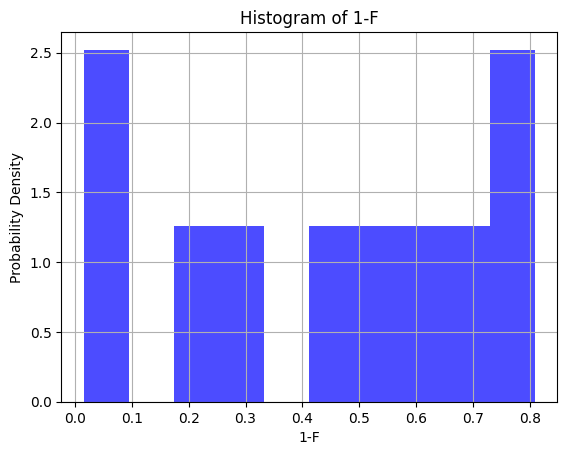

In [ ]:
results = []
phis = []
count = 0
T_sample = 10000.0
# test the stabullity of the optimization
print(f'Optimize under the same T: {T_sample}')
for i in range(10):
    count += 1
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    
    results.append(result[0]) # Append the minimum fidelity to the results list
    phis.append(result[1]) # Append the optimized phase angles to the phis list
    
    print(f"progress: {count}/20, minimum fidelity: {np.min(results)}")



In [ ]:
plt.hist(results, bins=10, density=True, alpha=0.7, color='blue')
plt.title('Histogram of 1-F')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('1-F')
plt.show()

In [ ]:
result_plot = []
count = 0 
for T in T_list:
    count += 1
    print(f"omptimize under the time: {T}')")
    print(f"progress: {count}/{len(T_list)}")
    sample = Optimalization_2_qubits(T) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    result_plot.append(result[0]) # Append the minimum fidelity to the results list




C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2


progress: 1/100
Optimization terminated successfully.
         Current function value: 0.600000
         Iterations: 0
         Function evaluations: 100
         Gradient evaluations: 1
progress: 2/100
Optimization terminated successfully.
         Current function value: 0.641755
         Iterations: 4
         Function evaluations: 800
         Gradient evaluations: 8
progress: 3/100
Optimization terminated successfully.
         Current function value: 0.309569
         Iterations: 4
         Function evaluations: 1200
         Gradient evaluations: 12
progress: 4/100
Optimization terminated successfully.
         Current function value: 0.599107
         Iterations: 5
         Function evaluations: 900
         Gradient evaluations: 9
progress: 5/100
Optimization terminated successfully.
         Current function value: 0.015571
         Iterations: 4
         Function evaluations: 1100
         Gradient evaluations: 11
progress: 6/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.600220
         Iterations: 5
         Function evaluations: 2711
         Gradient evaluations: 27
progress: 7/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.618461
         Iterations: 4
         Function evaluations: 3009
         Gradient evaluations: 30
progress: 8/100
Optimization terminated successfully.
         Current function value: 0.590085
         Iterations: 5
         Function evaluations: 900
         Gradient evaluations: 9
progress: 9/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.092536
         Iterations: 4
         Function evaluations: 4211
         Gradient evaluations: 42
progress: 10/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.151833
         Iterations: 3
         Function evaluations: 3111
         Gradient evaluations: 31
progress: 11/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.778154
         Iterations: 7
         Function evaluations: 4411
         Gradient evaluations: 44
progress: 12/100
Optimization terminated successfully.
         Current function value: 0.551316
         Iterations: 4
         Function evaluations: 900
         Gradient evaluations: 9
progress: 13/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.595767
         Iterations: 3
         Function evaluations: 3811
         Gradient evaluations: 38
progress: 14/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.744560
         Iterations: 6
         Function evaluations: 3311
         Gradient evaluations: 33
progress: 15/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.491911
         Iterations: 3
         Function evaluations: 3012
         Gradient evaluations: 30
progress: 16/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.381831
         Iterations: 2
         Function evaluations: 4411
         Gradient evaluations: 44
progress: 17/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.592809
         Iterations: 3
         Function evaluations: 3810
         Gradient evaluations: 38
progress: 18/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.319435
         Iterations: 2
         Function evaluations: 3111
         Gradient evaluations: 31
progress: 19/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.600220
         Iterations: 3
         Function evaluations: 5812
         Gradient evaluations: 58
progress: 20/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.445772
         Iterations: 3
         Function evaluations: 3910
         Gradient evaluations: 39
progress: 21/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.115620
         Iterations: 5
         Function evaluations: 3012
         Gradient evaluations: 30
progress: 22/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.092536
         Iterations: 4
         Function evaluations: 4811
         Gradient evaluations: 48
progress: 23/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.000105
         Iterations: 3
         Function evaluations: 5212
         Gradient evaluations: 52
progress: 24/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.115620
         Iterations: 2
         Function evaluations: 3512
         Gradient evaluations: 35
progress: 25/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.163166
         Iterations: 2
         Function evaluations: 4111
         Gradient evaluations: 41
progress: 26/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.449829
         Iterations: 3
         Function evaluations: 4112
         Gradient evaluations: 41
progress: 27/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.541278
         Iterations: 6
         Function evaluations: 3712
         Gradient evaluations: 37
progress: 28/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.272375
         Iterations: 5
         Function evaluations: 6512
         Gradient evaluations: 65
progress: 29/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.030150
         Iterations: 3
         Function evaluations: 3311
         Gradient evaluations: 33
progress: 30/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.343442
         Iterations: 3
         Function evaluations: 4311
         Gradient evaluations: 43
progress: 31/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.582645
         Iterations: 2
         Function evaluations: 4610
         Gradient evaluations: 46
progress: 32/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.229433
         Iterations: 2
         Function evaluations: 3511
         Gradient evaluations: 35
progress: 33/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.809754
         Iterations: 4
         Function evaluations: 3211
         Gradient evaluations: 32
progress: 34/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.525541
         Iterations: 4
         Function evaluations: 3411
         Gradient evaluations: 34
progress: 35/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.031754
         Iterations: 3
         Function evaluations: 4412
         Gradient evaluations: 44
progress: 36/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.593502
         Iterations: 5
         Function evaluations: 4512
         Gradient evaluations: 45
progress: 37/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.231001
         Iterations: 3
         Function evaluations: 5812
         Gradient evaluations: 58
progress: 38/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.001198
         Iterations: 2
         Function evaluations: 4112
         Gradient evaluations: 41
progress: 39/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.343442
         Iterations: 6
         Function evaluations: 3311
         Gradient evaluations: 33
progress: 40/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.351727
         Iterations: 4
         Function evaluations: 4412
         Gradient evaluations: 44
progress: 41/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.002356
         Iterations: 2
         Function evaluations: 3709
         Gradient evaluations: 37
progress: 42/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.287657
         Iterations: 2
         Function evaluations: 3012
         Gradient evaluations: 30
progress: 43/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.585620
         Iterations: 2
         Function evaluations: 3310
         Gradient evaluations: 33
progress: 44/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.751546
         Iterations: 4
         Function evaluations: 4912
         Gradient evaluations: 49
progress: 45/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.216631
         Iterations: 6
         Function evaluations: 3511
         Gradient evaluations: 35
progress: 46/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.004043
         Iterations: 3
         Function evaluations: 3912
         Gradient evaluations: 39
progress: 47/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.080062
         Iterations: 4
         Function evaluations: 3612
         Gradient evaluations: 36
progress: 48/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.163166
         Iterations: 3
         Function evaluations: 4611
         Gradient evaluations: 46
progress: 49/100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  H[0,1] = Omega[i]/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  H[1,0] = Omega[i].conj()/2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  H[2,3] = Omega[i]/sqrt2
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[3,2] = Omega[i].conj()/sqrt2
c:\Users\ASUS\anaconda3\envs\qec\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1848\916868080.py:18: ComplexWarning: Casting complex values

         Current function value: 0.367627
         Iterations: 3
         Function evaluations: 3712
         Gradient evaluations: 37
progress: 50/100


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(T_list, result_plot, color='blue', marker='o')
plt.title(r"Optimal 1-F vs $T\Omega_{max}$")
plt.xlabel(r'$T \Omega_{max}$')

plt.grid(True)
plt.show()